In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [2]:
# --- Offers Dataset
# TODO: change the offers dataset to one different from Turing Careers
with sqlite3.connect('./datasets/offers_dataset.db') as offers_conn:
    offers_frame = pd.read_sql('SELECT * FROM Offers', offers_conn)

offers_frame.drop_duplicates(inplace=True)
offers_frame

,Name,Description,Location
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia"
...,...,...,...
165,Data Scientist - Pharma,Akkodis è un leader globale nel mercato dell'i...,"Provincia di Torino, Piemonte"
166,DATA SCIENTIST | MACHINE LEARNING | BIG DATA,Techyon: Information Technology Recruitment Ex...,"Parma, Emilia-Romagna"
167,PDS AD&GMP Scientist I,Job DescriptionWhen you’re part of Thermo Fish...,20900 Monza
168,Junior Ethical Data Scientist,We are looking for an extremely BOLD & VISIONA...,None


In [3]:
# --- Skills Dataset
with sqlite3.connect('./datasets/skills_dataset.db') as skills_conn:
    skills_frame = pd.read_sql('SELECT * FROM Skills', skills_conn, index_col='ID')
    
skills_frame

,SKILL,TYPE
ID,,
0,JavaScript,Programming Language
1,HTML,Programming Language
2,Python,Programming Language
3,SQL,Programming Language
4,TypeScript,Programming Language
...,...,...
95,APT,Tool
96,Unity 3D,Tool
97,Pacman,Tool


## Offers skill extraction

In [4]:
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from utils import print_performance

def remove_symbols(description: str, remove_map: dict) -> str:
    """
    """
    for old, new in remove_map.items():
        description = description.replace(old, new)
    return description.lower()

def extract_symbols(text: str, available_symbols: list) -> set:
    """
    """
    out = set()
    for token in set(word_tokenize(text)):
        if token.lower() in available_symbols:
           out.add(token)
    return out

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Symbols to remove
punct = [p for p in punctuation]
punct.remove('+')
punct.remove('#')
punct.remove('.')

removal = {p: '' for p in punct}
removal['\n'] = ''
removal['/'] = ' '
removal['('] = ' '
removal[')'] = ' '
removal[','] = ' '

In [6]:
"""
@print_performance
def extract_skills(offers_df, skills_df):
    skill_list = [skill.lower() for skill in skills_df['SKILL'].tolist()]
    skill_vectors = []
    for skill in skill_list:
        presence_vector = offers_df.Description.map(lambda desc: skill in desc.lower()).rename(skill)
        skill_vectors.append(presence_vector)
    return pd.concat([vec for vec in skill_vectors], axis=1)   
"""

"\n@print_performance\ndef extract_skills(offers_df, skills_df):\n    skill_list = [skill.lower() for skill in skills_df['SKILL'].tolist()]\n    skill_vectors = []\n    for skill in skill_list:\n        presence_vector = offers_df.Description.map(lambda desc: skill in desc.lower()).rename(skill)\n        skill_vectors.append(presence_vector)\n    return pd.concat([vec for vec in skill_vectors], axis=1)   \n"

In [7]:

def extract_skills(offers_df, skills_df):
    skill_list = [skill.lower() for skill in skills_df['SKILL'].tolist()]
    skill_vectors = []
    for skill in skill_list:
        presence_vector = offers_df.Description.map(
            lambda desc: skill in extract_symbols(
                desc.lower(), 
                skill_list
            )
        ).rename(skill)
        skill_vectors.append(presence_vector)
    return pd.concat([vec for vec in skill_vectors], axis=1) 


In [8]:
skill_vector = extract_skills(offers_frame, skills_frame)
skill_vector

,javascript,html,python,sql,typescript,bash,java,c#,c++,c,...,msbuild,ansible,chocolatey,composer,llvm's clang,apt,unity 3d,pacman,pnpm,css
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
166,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
167,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
168,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Distribution Analysis
Given that the dataset is imbalanced more data/better data should be acquired

In [9]:
# --- Unbalanced Data
skills_headers = skill_vector.columns.tolist()
#skills_headers.remove('c')
#skills_headers.remove('go')
skill_vector = skill_vector[skills_headers]

In [10]:
skill_counts = skill_vector.sum()
skill_counts.rename("Count", inplace=True)

javascript    37
html          20
python        35
sql           25
typescript    11
              ..
apt            0
unity 3d       0
pacman         0
pnpm           0
css           19
Name: Count, Length: 96, dtype: int64

In [11]:
def plot_skills(count_frame):
    plt.figure(figsize=(10, 10))
    sns.barplot(x=count_frame.values, y=count_frame.index, palette="viridis")
    plt.title("Distribution of Skills in the Dataset")
    plt.xlabel("Count")
    plt.ylabel("Skills")
    plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_47916\1017160907.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_frame.values, y=count_frame.index, palette="viridis")


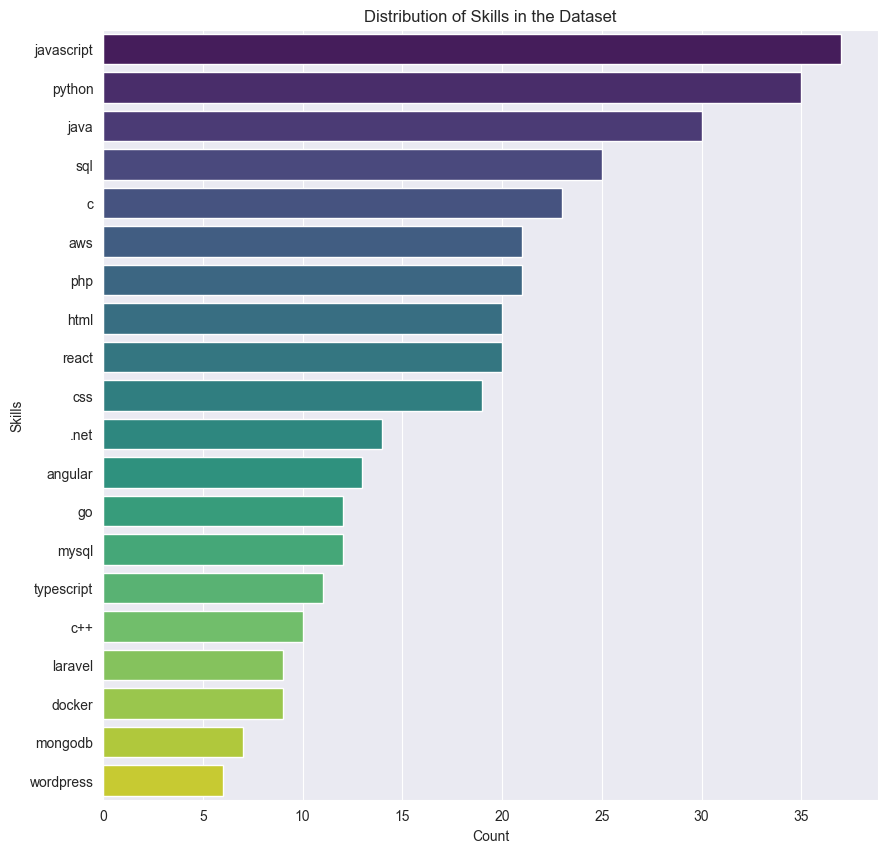

In [12]:
selected_skills = skill_counts[skill_counts >= 6].index
skill_vector = skill_vector[selected_skills]
skill_counts = skill_vector.sum()

plot_skills(skill_counts.sort_values(ascending=False))

## Association Rule Mining

### FP max Algorithm
One red-flag is that it doesn't show a single item set with HTML and CSS together.

In [13]:
from mlxtend.frequent_patterns import fpmax

@print_performance
def task_fp_max(vect):
    return fpmax(vect, use_colnames=True, min_support=0.05)

In [14]:
skill_sets = task_fp_max(skill_vector)
skill_sets

Done in 0.00


,support,itemsets
0,0.053571,"(laravel, php)"
1,0.053571,(docker)
2,0.059524,(c++)
3,0.065476,(typescript)
4,0.071429,(go)
5,0.071429,(mysql)
6,0.059524,"(javascript, angular)"
7,0.065476,"(c, .net)"
8,0.089286,"(html, css, javascript)"
9,0.053571,"(html, php)"


## Clustering Algorithm

## Export

In [15]:
with sqlite3.connect('./datasets/skill_sets.db') as out_conn:
    out_curs = out_conn.cursor()
    out_curs.execute('''
        CREATE TABLE IF NOT EXISTS SkillSets (
            ID INTEGER PRIMARY KEY,
            SKILLS TEXT
        )    
    ''')

    i = -1
    for skill_set in skill_sets['itemsets'].tolist():
        if len(skill_set) > 1: 
            skill_list = []
            
            for skill in skill_set:
                skill_list.append(skill)
                
            i += 1
            out_curs.execute('''INSERT INTO SkillSets VALUES (?, ?)''', (i, ', '.join(skill_list)))
            
    out_conn.commit()


In [16]:
with sqlite3.connect('./datasets/skill_sets.db') as test_conn:
        test_frame = pd.read_sql('SELECT * FROM SkillSets', test_conn, index_col='ID')

test_frame

,SKILLS
ID,
0,"laravel, php"
1,"javascript, angular"
2,"c, .net"
3,"html, css, javascript"
4,"html, php"
5,"react, javascript"
6,"php, javascript"
7,"java, c"
8,"python, sql"
